In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
from collections import Counter
import re
import seaborn as sns
#from emoji import UNICODE_EMOJI

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from verstack.stratified_continuous_split import scsplit 


Bad key "text.kerning_factor" on line 4 in
C:\Users\Imadeddine\anaconda3\envs\research\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Loading Clean Text

In [2]:
path = os.getcwd()
path_data_train = path + "\\covidChallenge\\data\\clean_text.csv"
path_data_eval = path + "\\covidChallenge\\data\\evaluation.csv"

In [3]:
data = pd.read_csv(path_data_train)
df_eval = pd.read_csv(path_data_eval)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665777 entries, 0 to 665776
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            665777 non-null  int64 
 1   retweet_count         665777 non-null  int64 
 2   user_verified         665777 non-null  int64 
 3   user_statuses_count   665777 non-null  int64 
 4   user_followers_count  665777 non-null  int64 
 5   user_friends_count    665777 non-null  int64 
 6   user_mentions         665777 non-null  int64 
 7   urls                  665777 non-null  int64 
 8   hashtags              665777 non-null  int64 
 9   wordnet_pos           665777 non-null  object
 10  lemma_str             662927 non-null  object
dtypes: int64(9), object(2)
memory usage: 55.9+ MB


> -Delete NaN rows

In [5]:
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662927 entries, 0 to 662926
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            662927 non-null  int64 
 1   retweet_count         662927 non-null  int64 
 2   user_verified         662927 non-null  int64 
 3   user_statuses_count   662927 non-null  int64 
 4   user_followers_count  662927 non-null  int64 
 5   user_friends_count    662927 non-null  int64 
 6   user_mentions         662927 non-null  int64 
 7   urls                  662927 non-null  int64 
 8   hashtags              662927 non-null  int64 
 9   wordnet_pos           662927 non-null  object
 10  lemma_str             662927 non-null  object
dtypes: int64(9), object(2)
memory usage: 55.6+ MB


In [6]:
data.columns

Index(['Unnamed: 0', 'retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'user_mentions', 'urls',
       'hashtags', 'wordnet_pos', 'lemma_str'],
      dtype='object')

In [7]:
data = data.drop(['user_verified'], axis=1)
data = data.drop(['user_statuses_count'], axis=1)
data = data.drop(['user_followers_count'], axis=1)
data = data.drop(['user_friends_count'], axis=1)
data = data.drop(['user_mentions'], axis=1)
data = data.drop(['urls'], axis=1)
data = data.drop(['wordnet_pos'], axis=1)
data = data.drop(['Unnamed: 0'], axis=1)

In [8]:
data = data.drop(['hashtags'], axis=1)

In [9]:
data

,retweet_count,lemma_str
0,0,smh give
1,0,u human think miss boat george
2,0,old dirty trick trump againlike dont know fauc...
3,0,seriously work 86 hour last check ’ even come ...
4,0,may almighty allah mercy u lagosians observed ...
...,...,...
662922,0,18 month dawg come man
662923,1,thank nurse stanfordemed family share covid19 ...
662924,8,post pearl palliative end life bereavement car...
662925,0,facial expression kind look answer oh wait ans...


### Creating Bag of Words

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
bow_converter = CountVectorizer(tokenizer=lambda doc: doc)

x = bow_converter.fit_transform(data['lemma_str'])
words = bow_converter.get_feature_names()

In [12]:
x

<662927x1789 sparse matrix of type '<class 'numpy.int64'>'
	with 11860200 stored elements in Compressed Sparse Row format>

In [13]:
len(words)

1789

In [14]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2]) 
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3])

In [15]:
bigram_converter

CountVectorizer(ngram_range=[2, 2],
                tokenizer=<function <lambda> at 0x000001EAA832B820>)

In [72]:
import csv
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from verstack.stratified_continuous_split import scsplit # pip install verstack

# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(data, data['retweet_count'], stratify=data['retweet_count'], train_size=0.7, test_size=0.3, random_state = 42)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_train, X_train['retweet_count'], \
                                                  test_size=0.1, random_state=21)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweet_count'], axis=1)
X_val = X_val.drop(['retweet_count'], axis=1)
X_test = X_test.drop(['retweet_count'], axis=1)

# You can examine the available features using X_train.head()

# We set up an Tfidf Vectorizer that will use the top 100 tokens from the tweets. We also remove stopwords.
# To do that we have to fit our training dataset and then transform both the training and testing dataset. 
vectorizer = TfidfVectorizer(max_features=100)
X_train = vectorizer.fit_transform(X_train['lemma_str'])
X_val = vectorizer.fit_transform(X_val['lemma_str'])
X_test = vectorizer.fit_transform(X_test['lemma_str'])

In [73]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Val dataset shape: ", X_val.shape)
print("-----------------------------------------------------")
print("\t Y_train dataset shape: ", y_train.shape)
print("\t Y_val dataset shape: ", y_val.shape)
print("-----------------------------------------------------")
print("\t X_Test dataset shape: ", X_test.shape)
print("\t Y_test dataset shape: ", y_test.shape)

	 Train dataset shape:  (417643, 100)
	 Val dataset shape:  (46405, 100)
-----------------------------------------------------
	 Y_train dataset shape:  (417643,)
	 Y_val dataset shape:  (46405,)
-----------------------------------------------------
	 X_Test dataset shape:  (198879, 100)
	 Y_test dataset shape:  (198879,)


In [78]:
print("Type: ", type(X_test))
print("Type: ", type(y_train))

Type:  <class 'scipy.sparse.csr.csr_matrix'>
Type:  <class 'pandas.core.series.Series'>


In [62]:
from sklearn.linear_model import LogisticRegression

def simple_logistic_classify(X_tr, y_tr, X_test, y_test, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', score)
    return model

In [63]:
#simple_logistic_classify(X_train, y_train, X_test, y_test)

In [64]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield np.array(X_batch), np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [85]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.01
NUM_FEATURES = X_train.shape[1]

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [87]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [95]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train.toarray(), dtype=torch.float32, device=device), \
                                               torch.tensor(y_train.values, dtype=torch.float32, device=device))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val.toarray(), dtype=torch.float32, device=device), \
                                               torch.tensor(y_val.values, dtype=torch.float32, device=device))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test.toarray(), dtype=torch.float32, device=device), \
                                              torch.tensor(y_test.values, dtype=torch.float32, device=device))

In [96]:
#train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
#val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
#test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [97]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [98]:
class Regression(nn.Module):
    def __init__(self, num_features):
        super(Regression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 256)
        self.layer_2 = nn.Linear(256, 64)
        #self.layer_3 = nn.Linear(64, 64)
        #self.layer_4 = nn.Linear(32, 28)
        #self.layer_5 = nn.Linear(28, 8)
        self.layer_out = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        #x = self.relu(self.layer_3(x))
        #x = self.relu(self.layer_4(x))
        #x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        #x = self.relu(self.layer_3(x))
        #x = self.relu(self.layer_4(x))
        #x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)

In [99]:
model = Regression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Regression(
  (layer_1): Linear(in_features=100, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [100]:
loss_stats = {
    'train': [],
    "val": []
}

In [101]:
for e in range(1, EPOCHS+1):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_loss_mae = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        loss_mae = nn.L1Loss()(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_loss_mae += loss_mae.item()
        
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_mae = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            mae_loss = nn.L1Loss()(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            val_epoch_mae += mae_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    print(f'\t   | MAE Train Loss: {train_epoch_loss_mae:.5f} | MAE Val Loss: {val_epoch_mae:.5f}')

Epoch 001: | Train Loss: 9059924.50137 | Val Loss: 3212294.45792
	   | MAE Train Loss: 3401839.50449 | MAE Val Loss: 10941138.02094
Epoch 002: | Train Loss: 9054083.38856 | Val Loss: 3210821.39314
	   | MAE Train Loss: 3442238.77064 | MAE Val Loss: 10825586.18738
Epoch 003: | Train Loss: 9051782.91599 | Val Loss: 3215253.00666
	   | MAE Train Loss: 3468282.50549 | MAE Val Loss: 9623133.26438
Epoch 004: | Train Loss: 9051582.39778 | Val Loss: 3217252.45592
	   | MAE Train Loss: 3444058.01200 | MAE Val Loss: 10807593.63363
Epoch 005: | Train Loss: 9051959.40013 | Val Loss: 3216925.11721
	   | MAE Train Loss: 3474412.61616 | MAE Val Loss: 10827919.83452
Epoch 006: | Train Loss: 9051786.26370 | Val Loss: 3220126.30484
	   | MAE Train Loss: 3455680.16019 | MAE Val Loss: 13370026.70320
Epoch 007: | Train Loss: 9052843.62326 | Val Loss: 3211593.70223
	   | MAE Train Loss: 3507885.23338 | MAE Val Loss: 11034116.76354
Epoch 008: | Train Loss: 9053430.25837 | Val Loss: 3209907.39092
	   | MAE Tr

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

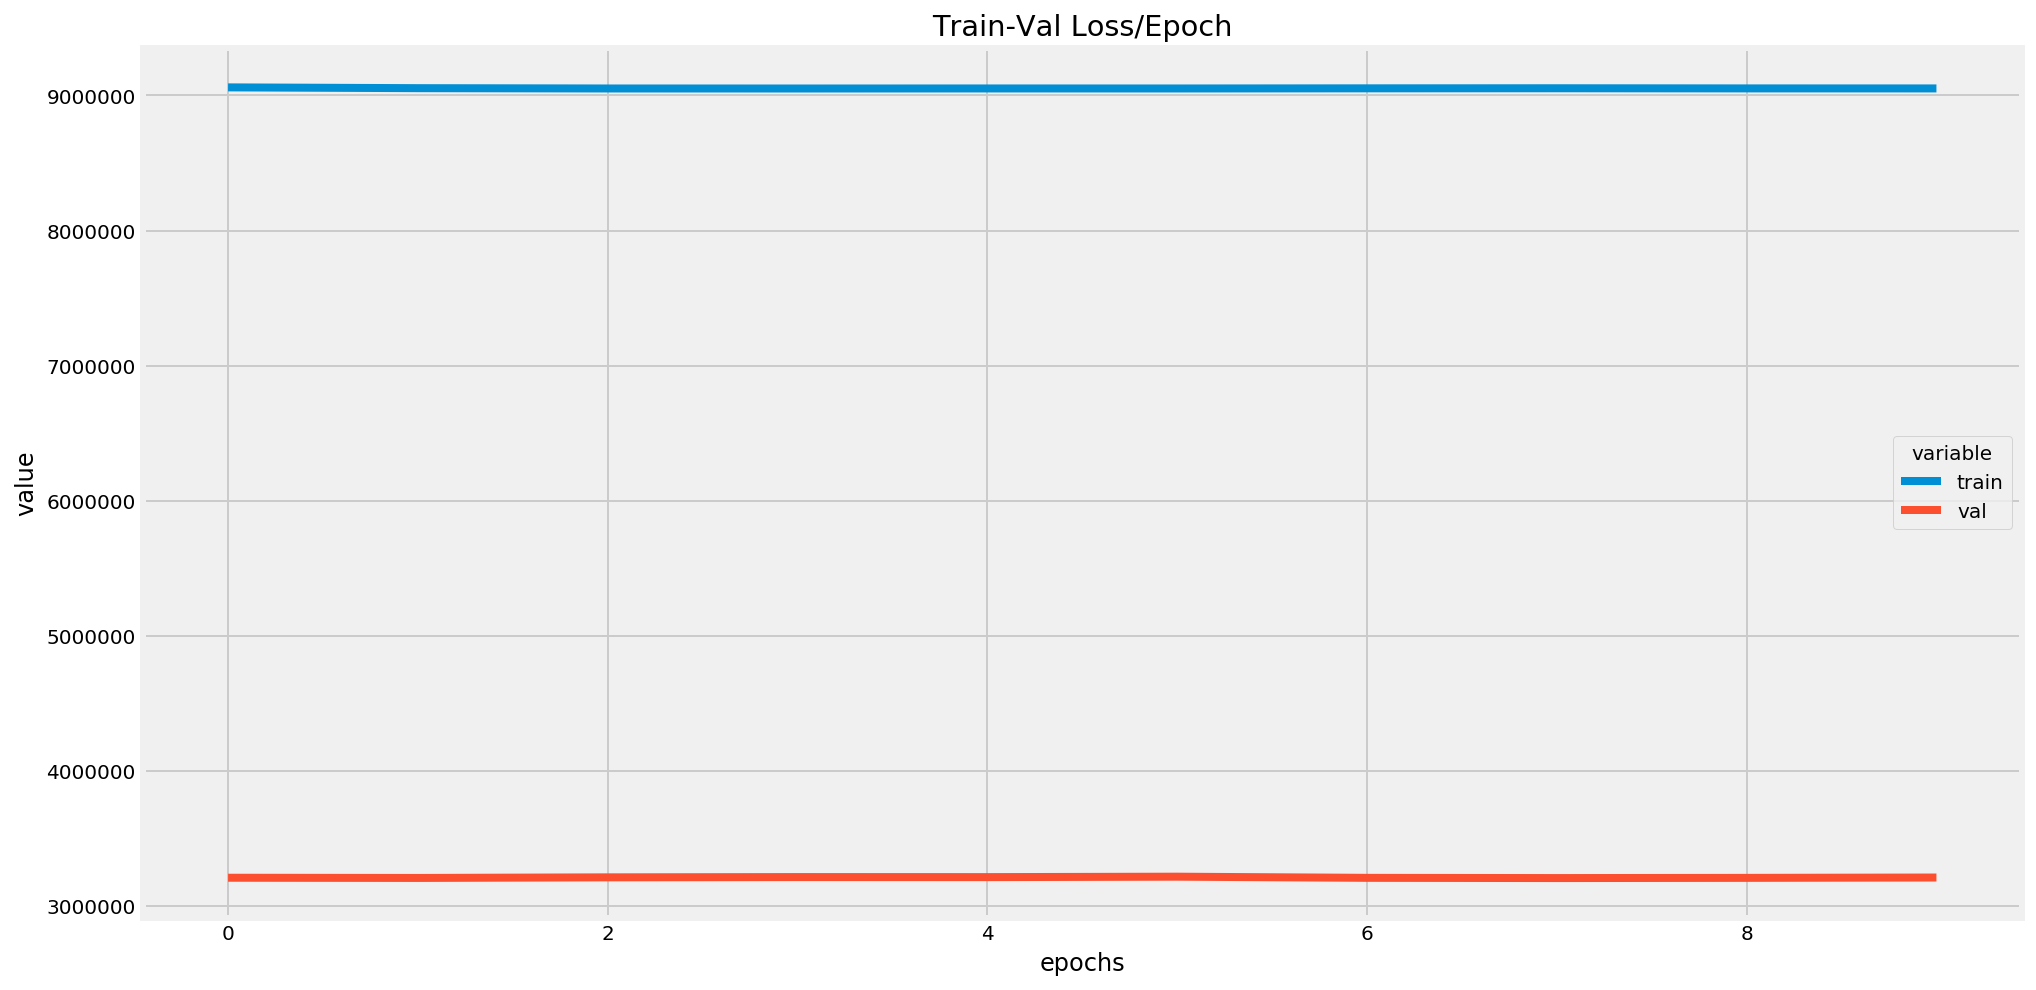

In [102]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [103]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [104]:
mse = mean_squared_error(y_test, y_pred_list)
mae = mean_absolute_error(y_test, y_pred_list)
print("\t Mean Squared Error :", mse)
print("\t mean_absolute_error :", mae)

	 Mean Squared Error : 7530550.123446975
	 mean_absolute_error : 243.97472915123183


In [ ]:
PATH = "NN_" + str(EPOCHS) + "_StandardScaler_epochs_" + str(int(mae)) + ".pt"
torch.save(model.state_dict(), PATH)